# Module 3.5 — Time to Recovery Is Not Symmetric
#### Background assumptions
- Outcome distributions are fixed
- No system rules or parameters are changed
- All equity paths are generated under identical conditions

Drawdowns are often perceived as reversible events.     
This module examines whether time to recover behaves symmetrically with respect to time to lose.

#### Purpose of this simulation

To measure how long equity paths take to recover after reaching a drawdown trough and how recovery time relates to drawdown depth.    
The simulation only measures the very first drawdown that occurs on a single equity path.

#### Common intuitive beliefs (to be examined)
- Large losses should recover proportionally faster
- Time lost and time regained are roughly symmetric
- Recovery speed reflects system quality

#### Objective
> To observe the nonlinearity between drawdown depth and time required to recover.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(90)

In [2]:
n_trades = 400
wins = 220
losses = n_trades - wins

outcomes = np.array([1]*wins + [-1]*losses)

In [3]:
def drawdown_recovery_stats(equity):
    """
    Measures drawdown relative to starting equity (index 0).

    Returns:
    - drawdown_depth : maximum dip below starting equity
    - drawdown_time  : time from start to worst point
    - recovery_time  : time from worst point to first recovery to start (NaN if never)
    """

    equity = np.asarray(equity)
    running_peak = np.maximum.accumulate(equity)

    below = equity < running_peak
    
    if not np.any(below):
        return None

    start = np.where(below)[0][0] -1
    peak_value = equity[start]

    recovery_idx = np.where(equity[start+1:] >= peak_value)[0]
    
    if len(recovery_idx) == 0:
        end = None
        drawdown_path = equity[start + 1:]
    else:
        end = start + 1 + recovery_idx[0]
        drawdown_path = equity[start + 1 : end + 1]

    
    trough_idx = np.argmin(drawdown_path)
    trough_value = drawdown_path[trough_idx]
    
    drawdown_depth = peak_value - trough_value
    drawdown_time = trough_idx + 1  # peak → trough
    
    if end is None:
        recovery_time = np.nan
    else:
        recovery_time = end - (start + 1 + trough_idx)

    return drawdown_depth, drawdown_time, recovery_time
    


In [4]:
n_paths = 5000

depths = []
loss_times = []
recovery_times = []

for _ in range(n_paths):
    path = np.cumsum(np.random.permutation(outcomes))
    d, loss_t, rec_t = drawdown_recovery_stats(path)
    
    if not np.isnan(rec_t):
        depths.append(d)
        loss_times.append(loss_t)
        recovery_times.append(rec_t)

depths = np.array(depths)
loss_times = np.array(loss_times)
recovery_times = np.array(recovery_times)


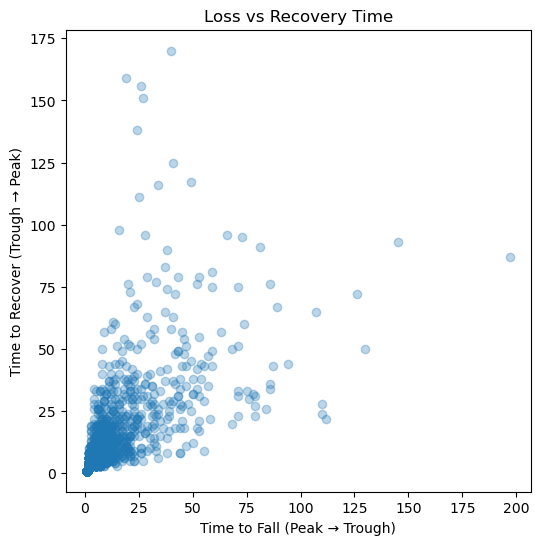

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(loss_times, recovery_times, alpha=0.3)
plt.xlabel("Time to Fall (Peak → Trough)")
plt.ylabel("Time to Recover (Trough → Peak)")
plt.title("Loss vs Recovery Time")
plt.show()


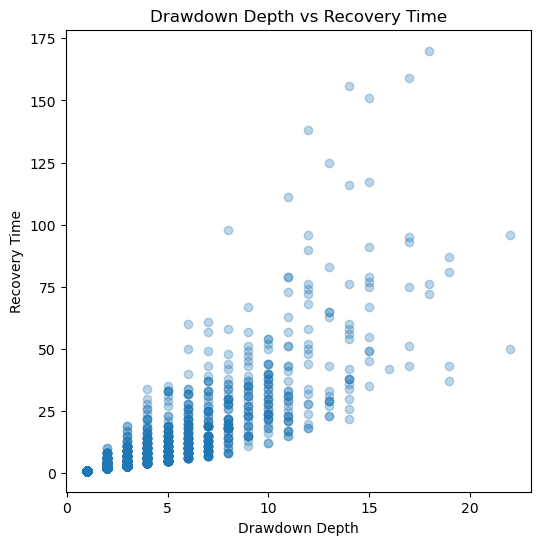

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(depths, recovery_times, alpha=0.3)
plt.xlabel("Drawdown Depth")
plt.ylabel("Recovery Time")
plt.title("Drawdown Depth vs Recovery Time")
plt.show()


In [7]:
for p in [50, 75, 90, 95]:
    print(f"{p}th percentile recovery time: {np.percentile(recovery_times, p):.0f} trades")


50th percentile recovery time: 1 trades
75th percentile recovery time: 4 trades
90th percentile recovery time: 11 trades
95th percentile recovery time: 22 trades


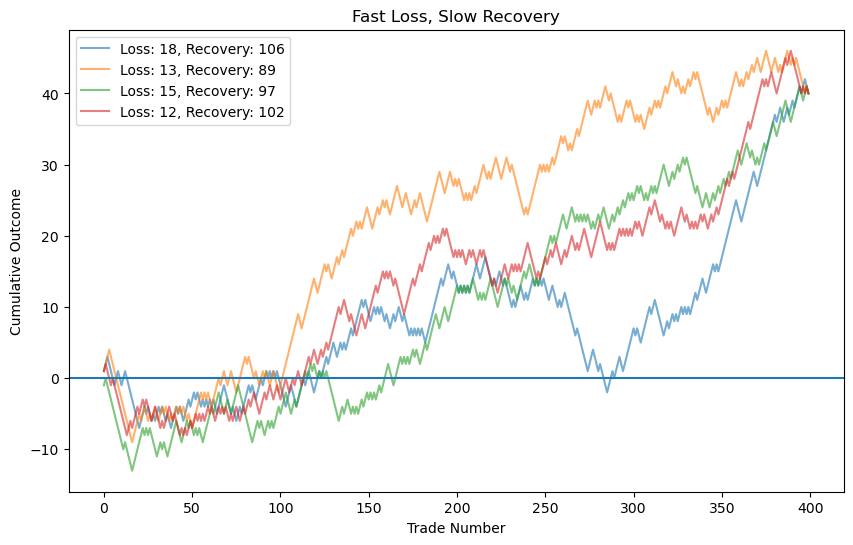

In [8]:
plt.figure(figsize=(10, 6))

shown = 0
while shown < 4:
    path = np.cumsum(np.random.permutation(outcomes))
    d, loss_t, rec_t = drawdown_recovery_stats(path)
    
    if not np.isnan(rec_t) and loss_t < 20 and rec_t > 80:
        plt.plot(path, label=f"Loss: {loss_t}, Recovery: {rec_t}" , alpha = 0.6)
        shown += 1

plt.axhline(0)
plt.legend()
plt.title("Fast Loss, Slow Recovery")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Outcome")
plt.show()



# Observations
- The time it takes for an equity path to fall into a drawdown is weakly related to the time it takes to recover from it.
- Many drawdowns form quickly but require disproportionately longer periods to return to their prior peak.
- Drawdown depth shows a clearer relationship with recovery time than drawdown duration, but the relationship remains highly dispersed.
- Median recovery times are short, yet the upper tail is long — a small fraction of paths experience very extended recoveries.
- This asymmetry arises even in systems with positive expectancy and no structural disadvantage.
- Visualizing individual paths shows that long recovery periods often consist of sideways or slowly rising equity, not continued losses.
- Recovery time reflects accumulation difficulty, not loss severity alone.

## Interpretation:
Losses compress in time; recoveries spread out. Linear intuition about “time to get back” does not hold in path-dependent systems.